In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

In [2]:
T = BigFloat

BigFloat

In [96]:
beta::Float64 = 10
wmax::Float64 = 100
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 10.0, ωmax = 100.0

In [97]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [98]:
nsize::Int64 = 128
t_pra::Float64 = 0.0
filling::Float64 = 1.0
scale::Float64 = 0.1
#U::Float64 = 0.4 ##w=4
#U::Float64 = 0.2 ##w=2
U::Float64 = 0.1 ##w=1
function single_Hami(x::Float64, y::Float64, t::Float64, t_pra::Float64)::Float64
    e::Float64 = -2.0*t*(cos(x)+cos(y)) + 4.0*t_pra*cos(x)*cos(y)                   
end
hami::Function = (x,y) -> single_Hami(x,y,0.125,t_pra)
#U::Float64 = 0.5
#hami::Function = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [99]:
ratio_U = 0.0
precision = 1e-4
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
;

In [100]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(gkf0, lat, basis)
;

In [101]:
# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
;

In [102]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

36

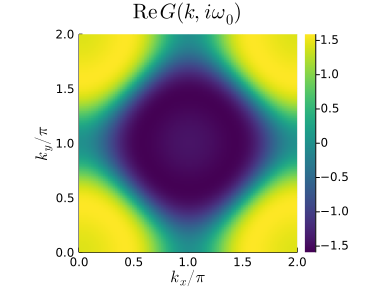

In [103]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

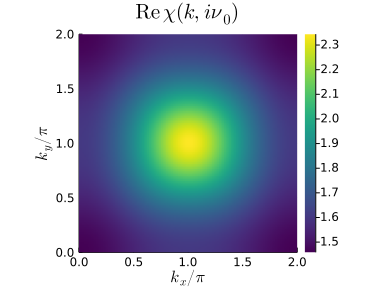

In [104]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [105]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [106]:
chisf = chi0kf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

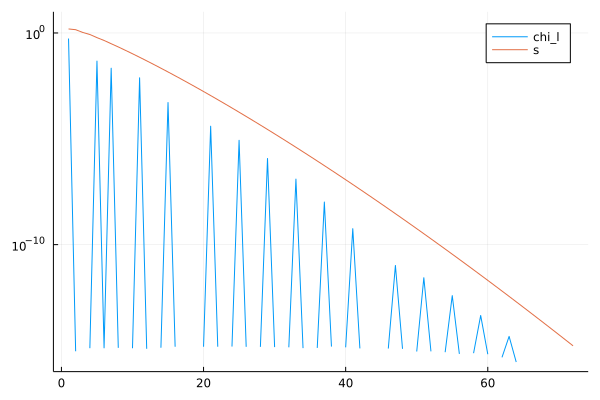

In [107]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

In [108]:
#smpl_wn_b_dense = MatsubaraSampling(basis.basis_b, SparseIR.BosonicFreq.(collect(-2332:2:2332)))
#chisl_d = fit(basis.smpl_wn_b, chisf)
#chisf_d = evaluate(smpl_wn_b_dense, chisl_d)
#deleteat!(chisf_d, 1167)
#chisf_d[1167]=0.0
#chisl_d = fit(smpl_wn_b_dense, chisf_d)
;

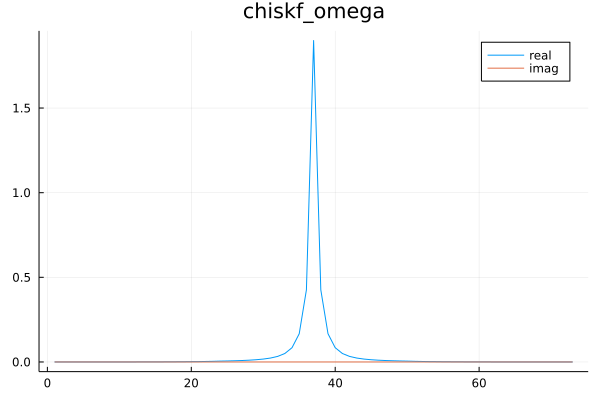

In [109]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

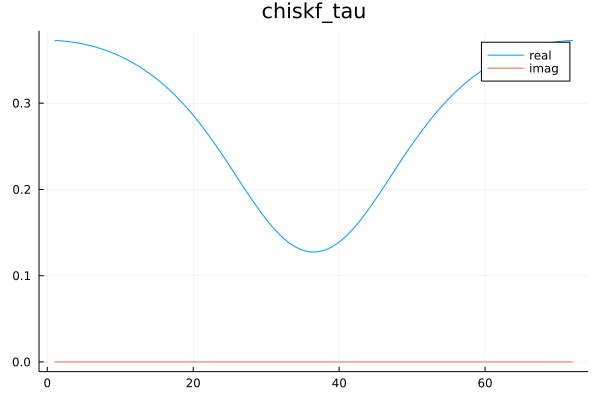

In [110]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [111]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

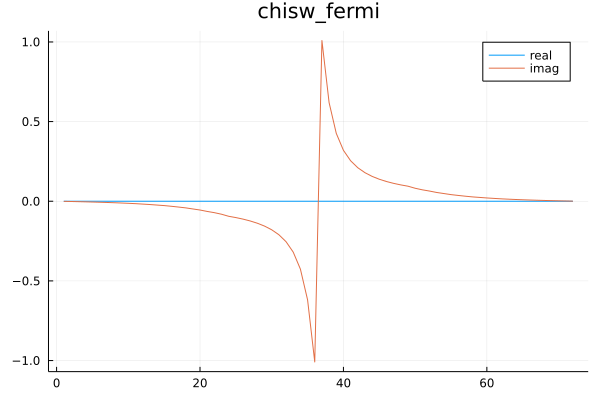

In [112]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [113]:
setprecision(512)

512

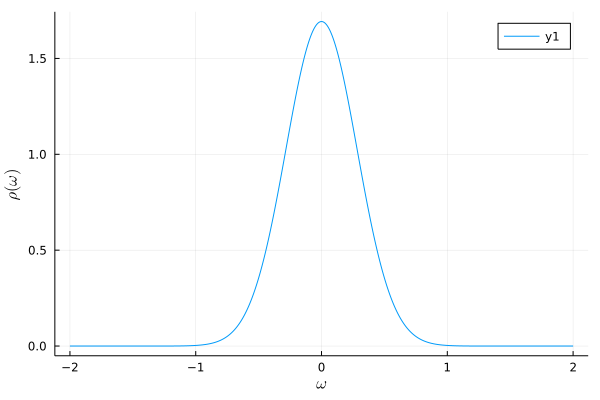

In [114]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
weight = 1.2
rho(omega) = weight*gaussian(omega, 0.0, 0.4)  
#+ 0.5*gaussian(omega, 0.0, 0.1) 
#rho(omega) = weight*gaussian(omega, 0.0, 0.1)  
omegas = LinRange(-2, 2, 1000)
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [115]:
sum_rule = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))
#sum_rule = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl)) + weight

0.745447255668058

In [116]:
rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
gl = - basis.basis_f.s .* rhol
gw = evaluate(basis.smpl_wn_f, gl)
;

In [117]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [138]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    input_chi[i]  = 0.0 - im*imag(chisw[hnw+i])
    #input_chi[i]  = - chisw[hnw+i]
    #input_chi[i]  = -chisw[hnw+i] + gw[hnw+i]
end

In [143]:
N_real    =  6000
omega_max =  2.0
eta       =  0.05
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
#1000 → 2000
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
N_imag    =  hnw
println("N_imag $(N_imag)")

N_imag is setted as 10
N_imag 36


In [144]:
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum_rule, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is non positive semi-definite matrix in Schur method.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

In [56]:
function exact_suscep(qx, qy, omega, nsize, beta, hami)
    chi = zeros(ComplexF64, length(omega))
    for iomega in 1:length(omega)
        for ix in 1:nsize, iy in 1:nsize
            kx::Float64 = 2*π*(ix-1)/nsize
            ky::Float64 = 2*π*(iy-1)/nsize
            ek  = hami(kx,ky)
            ekq = hami(kx-qx,ky-qy)
            chi[iomega] += -(IRFLEX.fermi_dirac(ekq,beta)-IRFLEX.fermi_dirac(ek,beta))/(omega[iomega]+ekq-ek)
        end
        chi[iomega] = chi[iomega]/(nsize*nsize)
    end
    return chi
end

exact_suscep (generic function with 1 method)

In [131]:
exa_freq = Array{Complex{T}}(collect(LinRange(-omega_max, omega_max, 1000))) .+ eta * im
#exa_freq = Array{Complex{T}}(collect(LinRange(-omega_max, omega_max, 1000))) .+ 0.01 * im
exa_chi = exact_suscep(π,π,ComplexF64.(exa_freq),nsize,SparseIR.β(basis),hami)
;

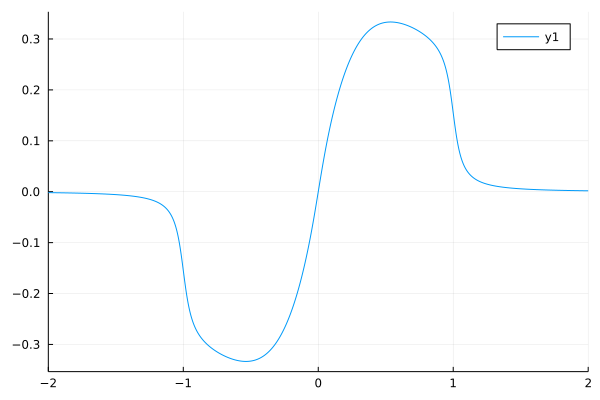

In [132]:
plot(xlim = [-2,2])
plot!(real.(exa_freq), imag.(exa_chi)/pi)

In [134]:
exa_chis = exa_chi ./ (1.0 .- lat.U*exa_chi)
;

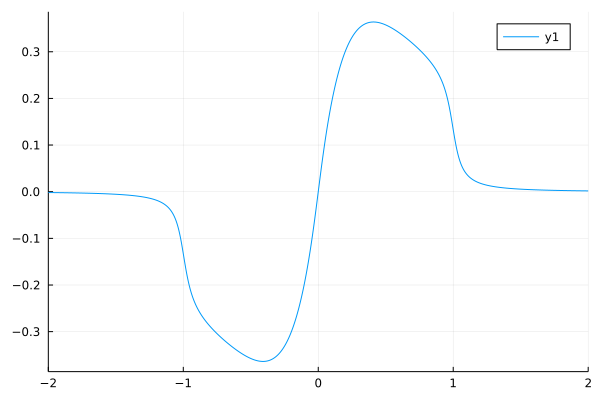

In [135]:
plot(xlim = [-2,2])
plot!(real.(exa_freq), imag.(exa_chis)/pi)

In [127]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, true)
#@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, true, mesh=:log)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     3.632454e-02     4.886213e-02
 * time: 0.0001819133758544922
     1     2.452837e-02     3.006200e-02
 * time: 2.7626938819885254
     2     2.156045e-02     4.614431e-02
 * time: 5.863262891769409
     3     1.147811e-02     4.293897e-02
 * time: 8.377670049667358
     4     5.599098e-03     1.028196e-02
 * time: 10.30439305305481
     5     5.176064e-03     1.708490e-03
 * time: 11.605663061141968
     6     5.161090e-03     7.317849e-05
 * time: 12.84003496170044
     7     5.161007e-03     9.312391e-06
 * time: 14.060081958770752
     8     5.161006e-03     5.403769e-07
 * time: 15.933724880218506
     9     5.161006e-03     7.629253e-08
 * time: 17.084655046463013
    10     5.161006e-03     3.846037e-09
 * time: 18.92335295677185
max_theta=0.552437541390814410409852957070606240690126198170852058051136907187503343130467581195529124912221332332511912123038489376720648755046359705690931695

In [128]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     5.161006e-03     3.846037e-09
 * time: 0.0001690387725830078
max_theta=0.552437541390814410409852957070606240690126198170852058051136907187503343130467581195529124912221332332511912123038489376720648755046359705690931695197195893
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     5.161006e-03     5.762287e-03
 * time: 0.00019311904907226562
     1     4.962822e-03     4.064847e-03
 * time: 2.80755615234375
     2     4.803278e-03     3.796413e-03
 * time: 5.532029151916504
     3     4.685092e-03     6.290390e-03
 * time: 7.611706018447876
     4     4.508720e-03     4.939545e-03
 * time: 10.37138319015503
     5     4.398607e-03     3.814969e-03
 * time: 12.449694156646729
     6     4.338365e-03     4.862004e-03
 * time: 14.531399011611938
     7     3.362019e-03     9.680727e-03
 * time: 17.293867111206055
     8     2.366357e-03     3.515957e-03
 * time: 19.38884210586548
     9     2.23967

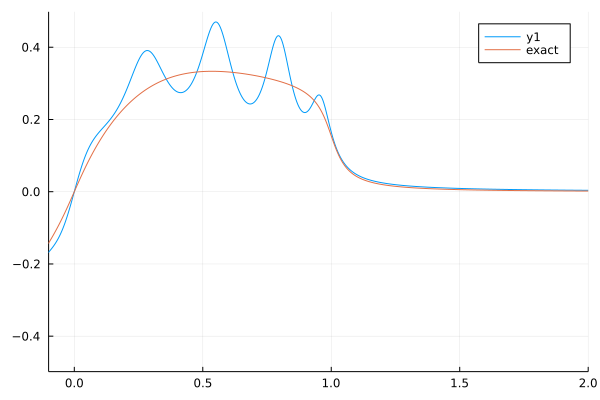

In [145]:
plot(xlim = [-0.1,2])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
#plot!(real.(raw_reals.freq), (imag.(raw_reals.val/pi)- rho.(real.(raw_reals.freq))).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(real.(exa_freq), imag.(exa_chi)/pi,label="exact")

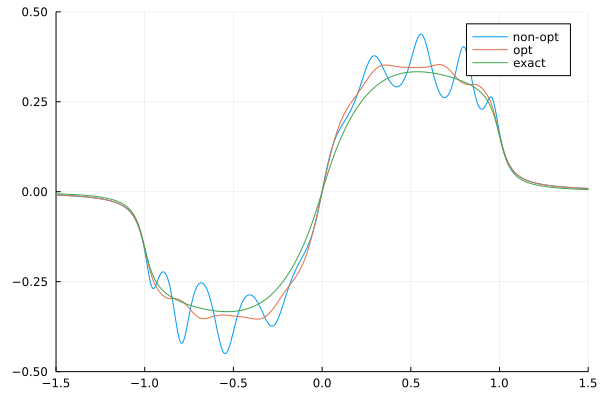

In [136]:
plot(xlim = [-1.5,1.5],ylim= [-0.5,0.5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
#plot!(real.(raw_reals.freq), (imag.(raw_reals.val/pi)-rho.(real.(raw_reals.freq))).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)-rho.(real.(sol.reals.freq))).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")
plot!(real.(exa_freq), imag.(exa_chi)/pi,label="exact")

In [142]:
plot(xlim = [-2,2])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/(pi*scale)),marker=:+)
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/(pi*scale))))
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [38]:
ComplexF64.(raw_reals.freq[1])

-2.0 + 0.001im